# Autoencoders
Autoencoders are a class of neural network that attempt to recreate the input
as their target using back-propagation. An autoencoder consists of two parts; an **encoder** and a **decoder**. The encoder will read the input and compress it to a compact representation, and the decoder will read the compact representation and recreate the input from it. In other words, the autoencoder tries to learn the identity function by minimizing the reconstruction error. They have an inherent capability to learn
a compact representation of data. They are at the center of deep belief networks
and find applications in image reconstruction, clustering, machine translation,
and much more.

This exercise aims to test your understanding of autoencoder architecture, and how it can be used to denoise an image. We will build a convolutional autoencoder. Combining your knowledge of a Vanilla/Denoising Autoencoder and Convolutional Networks.

The notebook has five Exercises followed by an optional exercise.

In [24]:
#@title Import Modules 

import numpy as np
import tensorflow as tf
import tensorflow.keras as K
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, UpSampling2D


np.random.seed(11)
tf.random.set_seed(11)

## AutoEncoder  Architecture
The number of hidden units in the autoencoder is typically less than the number of input (and output) units. This forces the encoder to learn a compressed representation of the input, which the decoder reconstructs. If there is a structure in the input data in the form of correlations between input features, then the autoencoder will discover some of these correlations, and end up learning a low-dimensional representation of the data similar to that learned using principal component analysis (PCA).

Once trained
* We can discard **decoder** and use **Encoder** to optain a compact representation of input.
* We can cascade Encoder to a classifier.

The encoder and decoder components of an autoencoder can be implemented using either dense, convolutional, or recurrent networks, depending on the kind of data that is being modeled.

Below we define an encoder and a decoder using Convolutional layers. Both consist of three convolutional layers. Each layer in Encoder has a corresponding layer in decoder, thus in this case it is like three autoencoders stacked over each other. This is also called **Stacked Autoencoders** 

![](https://drive.google.com/uc?id=1UzM67qf1VE_8akrCgiohKjUIHoO_2x4E)



In [25]:
#@title Encoder
class Encoder(K.layers.Layer):
    def __init__(self, filters):
        super(Encoder, self).__init__()
        self.conv1 = Conv2D(filters=filters[0], kernel_size=3, strides=1, activation='relu', padding='same')
        self.conv2 = Conv2D(filters=filters[1], kernel_size=3, strides=1, activation='relu', padding='same')
        self.conv3 = Conv2D(filters=filters[2], kernel_size=3, strides=1, activation='relu', padding='same')
        self.pool = MaxPooling2D((2, 2), padding='same')
               
    
    def call(self, input_features):
        x = self.conv1(input_features)
        #print("Ex1", x.shape)
        x = self.pool(x)
        #print("Ex2", x.shape)
        x = self.conv2(x)
        x = self.pool(x)
        x = self.conv3(x)
        x = self.pool(x)
        return x
        

In [26]:
#@title Decoder
class Decoder(K.layers.Layer):
    def __init__(self, filters):
        super(Decoder, self).__init__()
        self.conv1 = Conv2D(filters=filters[2], kernel_size=3, strides=1, activation='relu', padding='same')
        self.conv2 = Conv2D(filters=filters[1], kernel_size=3, strides=1, activation='relu', padding='same')
        self.conv3 = Conv2D(filters=filters[0], kernel_size=3, strides=1, activation='relu', padding='valid')
        self.conv4 = Conv2D(1, 3, 1, activation='sigmoid', padding='same')
        self.upsample = UpSampling2D((2, 2))
  
    def call(self, encoded):
        x = self.conv1(encoded)
        #print("dx1", x.shape)
        x = self.upsample(x)
        #print("dx2", x.shape)
        x = self.conv2(x)
        x = self.upsample(x)
        x = self.conv3(x)
        x = self.upsample(x)
        return self.conv4(x)

## Denoising Autoencoder

When we train the autoencoder, we can train it directly on the raw images or we can add noise to the input images while training. When the autoencoder is trained on noisy data, it gets an even interesting property--it can reconstruct noisy images. In other words--you give it an image with noise and it will remove the noise from it.

## Exercise 1:
In this exercise we will train the stacked autoencoder in four steps:
* In [Step 1](#step1) choose the noise = 0
* Complete the [Step 2](#step2)
* In the [Step 3](#step3) choose filters as [16, 32, 64] for Encoder and [64, 32, 16] for Decoder.
* Perform [Step 4](#step4) for batch size of 64 and 10 epochs
* Reflect on the plotted images what do you see?

**Answer 1** (Double click to edit)*italicized text*

<a id='step1'></a>
### Step 1:
Read the dataset, process it for noise = 0

In [48]:
#@title Dataset Reading and Processing
Noise = 0.5 #@param {type:"slider", min:0, max:1, step:0.1}
(x_train, _), (x_test, _) = K.datasets.mnist.load_data()

x_train = x_train / 255.
x_test = x_test / 255.

x_train = np.reshape(x_train, (len(x_train),28, 28, 1))
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))

noise = Noise
x_train_noisy = x_train + noise * np.random.normal(loc=0.0, scale=1.0, size=x_train.shape)
x_test_noisy = x_test + noise * np.random.normal(loc=0.0, scale=1.0, size=x_test.shape)

x_train_noisy = np.clip(x_train_noisy, 0, 1)
x_test_noisy = np.clip(x_test_noisy, 0, 1)

x_train_noisy = x_train_noisy.astype('float32')
x_test_noisy = x_test_noisy.astype('float32')

<a id='another_cell'></a>
### Step 2

You need to complete the code below. We will be using the Encoder and Decoder architectures that we have defined above to build an autoencoder. In the code below replace `...` with right code. 

In [41]:
class Autoencoder(K.Model):
    def __init__(self, filters_encoder, filters_decoder):
        super(Autoencoder, self).__init__()
        self.loss = []
        self.encoder = Encoder(filters_encoder)
        self.decoder = Decoder(filters_decoder)

    def call(self, input_features):
        #print(input_features.shape)
        encoded = self.encoder(input_features)
        #print(encoded.shape)
        reconstructed = self.decoder(encoded)
        #print(reconstructed.shape)
        return reconstructed


## Exercise 2:
In this exercise we will make only one change, in step 3 choose filters as: `[16, 32, 64]` for both Encoder and Decoder.
 Try training the Autoencoder. What happens? Why do you think it is so?

**Answer 2**
The numbers are accurately reconstructed and are slightly clearer.

## Exercise 3:

Now we will introduce noise of 0.2 in the training dataset. Train an autoencoder with filters [64,32,16] for encoder and [16,32,64] for decoder and observe the reconstrucred images.


What do you find? Is the autoencoder able to recognize noisy digits?


**Answer 3**
The numbers are accurately reconstructed and are clearer than with 0 noise. Beginning to notice numbers smear/blur a bit.

## Exercise 4:

Let us be more adventurous with the same Encoder-Decoder architecture, we increase the noise and observe the reconstrucred images.


What do you find? Till what noise value is the autoencoder able to reconstruct images? Till what noise level you (human) can recognize the digits in the noisy image.


**Answer 4** It takes close to 45 minutes for me to run 1 test with my current GPU, I'm not able to rerun multiple tests to answer this question. I would guess reconstruction fails at a later noise level (noise~0.8) than what a human can recognise the reconstructed digits as (noise~0.7).

<a id='step3'></a>

### Step 3:

We have built Convolutional Autoencoder. That is both Encoder and Decoder are buit using Convolutional layers. Below you need to select 

In [45]:
#@title Select Filters for Encoder & Decoder
filter_encoder_0 = 64 #@param {type:"slider", min:8, max:256, step:2}
filter_encoder_1 = 32 #@param {type:"slider", min:8, max:256, step:2}
filter_encoder_2 = 16 #@param {type:"slider", min:8, max:256, step:2}

filters_en = [filter_encoder_0,filter_encoder_1,filter_encoder_2]


filter_decoder_0 = 16 #@param {type:"slider", min:8, max:256, step:2}
filter_decoder_1 = 32 #@param {type:"slider", min:8, max:256, step:2}
filter_decoder_2 = 64 #@param {type:"slider", min:8, max:256, step:2}

filters_de = [filter_decoder_0,filter_decoder_1,filter_decoder_2]


model = Autoencoder(filters_en, filters_de)

model.compile(loss='binary_crossentropy', optimizer='adam')


### Step 4:
Choose the appropriate batch_size and epochs

In [46]:
#@title Train the model
BATCH_SIZE = 132 #@param {type:"slider", min:32, max:2000, step:10}
EPOCHS = 13 #@param {type:"slider", min:1, max:100, step:1}
batch_size = BATCH_SIZE
max_epochs = EPOCHS
loss = model.fit(x_train_noisy,
                x_train,
                validation_data=(x_test_noisy, x_test),
                epochs=max_epochs,
                batch_size=batch_size)


Epoch 1/13
455/455 [==============================] - 140s 305ms/step - loss: 0.1552 - val_loss: 0.1064
Epoch 2/13
455/455 [==============================] - 136s 299ms/step - loss: 0.1009 - val_loss: 0.0943
Epoch 3/13
455/455 [==============================] - 137s 301ms/step - loss: 0.0924 - val_loss: 0.0887
Epoch 4/13
455/455 [==============================] - 137s 302ms/step - loss: 0.0881 - val_loss: 0.0855
Epoch 5/13
455/455 [==============================] - 144s 317ms/step - loss: 0.0854 - val_loss: 0.0832
Epoch 6/13
455/455 [==============================] - 139s 307ms/step - loss: 0.0835 - val_loss: 0.0813
Epoch 7/13
455/455 [==============================] - 141s 310ms/step - loss: 0.0820 - val_loss: 0.0804
Epoch 8/13
455/455 [==============================] - 141s 310ms/step - loss: 0.0807 - val_loss: 0.0792
Epoch 9/13
455/455 [==============================] - 140s 308ms/step - loss: 0.0797 - val_loss: 0.0789
Epoch 10/13
455/455 [==============================] - 149s 328m

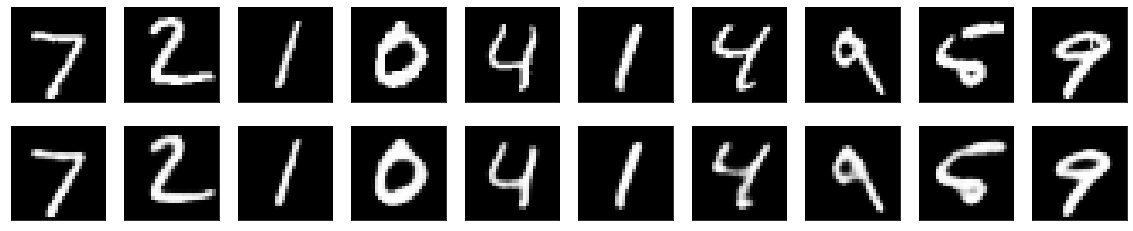

In [47]:
#@title Reconstructed images
number = 10  # how many digits we will display
plt.figure(figsize=(20, 4))
for index in range(number):
    # display original
    ax = plt.subplot(2, number, index + 1)
    plt.imshow(x_test_noisy[index].reshape(28, 28), cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, number, index + 1 + number)
    plt.imshow(tf.reshape(model(x_test_noisy)[index], (28, 28)), cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

## Optional Exercise
Construct a Sparse Autoencoder with Dense layer/s, train it on noisy images as before. See how the hidden dimensions influence the reconstruction. Which is one is better for denoising, the convolution Encoder/Decoder or Dense Encoder/Decoder, why?